In [569]:
%load_ext lab_black

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import math
import tensorflow as tf
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from textblob import Word
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
    OrdinalEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier, SGDRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    AdaBoostClassifier,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    VotingClassifier,
    StackingRegressor,
    StackingClassifier,
    ExtraTreesRegressor,
    ExtraTreesClassifier,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    HashingVectorizer,
)
from lightgbm import LGBMRegressor, LGBMClassifier
import scipy
from xgboost import XGBRegressor, XGBClassifier
from pprint import pprint
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.kernel_ridge import KernelRidge
from joblib import Parallel, delayed
from tune_sklearn import TuneGridSearchCV
import warnings
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import pycountry
import wordcloud
from nltk import pos_tag, word_tokenize
from sklearn.pipeline import make_pipeline
import re
from pprint import pprint
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

sns.reset_defaults()

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [534]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
train["istrain"] = 1
test["istrain"] = 0
traintest = pd.concat([train, test], axis=0).reset_index()
traintest["is_ready_to_move"] = traintest.availability == "Ready To Move"
traintest["avai_date"] = traintest.availability.str.extract("^(\d+)-")
traintest["avai_month"] = traintest.availability.str.extract(".*-(\w+).*")
traintest["area_size"] = traintest["size"]  # . rename for autocompletion
traintest["num_bedroom"] = traintest.area_size.str.extract("^(\d+).*")
traintest["num_bedroom_filled"] = traintest["num_bedroom"].fillna(2).astype(int)
traintest["is_bhk"] = traintest.area_size.str.contains("BHK")
traintest["is_1room"] = traintest.num_bedroom_filled == 1
traintest["total_sq"] = traintest.total_sqft
traintest["area_type"] = traintest["area_type"].astype("category")
traintest["bath_filled"] = traintest.bath.fillna(2)
traintest["avai_month_filled"] = traintest.avai_month.apply(
    lambda x: x
    if pd.notnull(x)
    else random.choice(traintest.avai_month.value_counts().keys())
)
traintest["avai_date_filled"] = traintest.avai_date.apply(
    lambda x: x
    if pd.notnull(x)
    else random.choice(traintest.avai_date.value_counts().keys())
)
traintest["is_bhk"].fillna(False, inplace=True)
traintest["location"] = traintest.location.str.lower()
traintest["location"].fillna("anantapura", inplace=True)  # special NAN
traintest["society"] = traintest.society.str.lower()
traintest["exists_society"] = traintest.society.notnull()
traintest["society_filled"] = traintest["society"].fillna("INVALID")
traintest["society_filled"] = traintest.society_filled.astype(str)
traintest["society_split_len"] = traintest.society.astype(str).apply(
    lambda x: len(x.split())
)
traintest["society_freq"] = traintest.society.map(traintest.society.value_counts())
traintest["area_type_freq"] = traintest.area_type.map(
    traintest.area_type.value_counts()
).astype(int)
traintest["area_type_freq_inv"] = 1 / traintest.area_type_freq
traintest["contains_interesting_keyword"] = traintest.location.str.contains(
    "(road|city|layout|airport|phase)"
)

traintest["location_society"] = (
    traintest["location"] + " " + traintest["society_filled"]
)


def process_total_sq(sqft):
    try:
        return float(sqft)
    except:
        if "-" in sqft:
            return np.mean(list(float(i) for i in sqft.split("-")))
        num = float(re.findall("[\d.]+", sqft)[0])
        if "Sq. Meter" in sqft:
            return num * 10.764
        elif "Acres" in sqft:
            return num * 43560
        elif "Sq. Yards" in sqft:
            return num * 9
        elif "Cents" in sqft:
            return num * 435.6
        elif "Guntha" in sqft:
            return num * 1089
        elif "Perch" in sqft:
            return num * 324
        else:
            return np.nan


traintest["total_sq"] = traintest["total_sqft"].apply(process_total_sq)
traintest["total_sq"].fillna(440.0, inplace=True)  # this is the median of 1RK house
traintest["total_sq_log"] = np.log(traintest.total_sq)
traintest.loc[traintest.istrain == 1, "price_per_sq"] = (
    traintest[traintest.istrain == 1].price / traintest[traintest.istrain == 1].total_sq
)
traintest["price_log"] = np.log(traintest.price)


def metric(y_true, y_pred):
    y_true = math.e ** y_true
    y_pred = math.e ** y_pred
    return 1 - np.sqrt(np.square(np.log10(y_pred + 1) - np.log10(y_true + 1)).mean())


def cv(m):
    results = cross_validate(
        m,
        traintest[traintest.istrain == 1],
        np.log(traintest[traintest.istrain == 1].price),
        scoring=make_scorer(metric, greater_is_better=True),
        n_jobs=-1,
        cv=5,
    )
    pprint(results)
    print(np.mean(results["test_score"]))


def submit(m):
    m.fit(
        traintest[traintest.istrain == 1],
        np.log(traintest[traintest.istrain == 1].price),
    )
    price = m.predict(traintest[traintest.istrain == 0])
    price = math.e ** price
    test_submit = pd.read_csv("Test.csv")
    test_submit.price = price
    test_submit.to_excel("submission.xlsx")
    print("done")


# fix data entry error
traintest.at[13414, "total_sq"] = 4000
traintest.at[11558, "total_sq"] = 6000
traintest.at[5970, "total_sq"] = 450
traintest.at[4972, "total_sq"] = 5000
traintest.at[4086, "total_sq"] = 1000
traintest.at[1122, "total_sq"] = 2400
traintest.at[1020, "total_sq"] = 1500
traintest.at[349, "total_sq"] = 1100

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [467]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               14800 non-null  int64   
 1   area_type           14800 non-null  category
 2   availability        14800 non-null  object  
 3   location            14800 non-null  object  
 4   size                14782 non-null  object  
 5   society             8672 non-null   object  
 6   total_sqft          14800 non-null  object  
 7   bath                14720 non-null  float64 
 8   balcony             14122 non-null  float64 
 9   price               13320 non-null  float64 
 10  istrain             14800 non-null  int64   
 11  is_ready_to_move    14800 non-null  bool    
 12  avai_date           3039 non-null   object  
 13  avai_month          3039 non-null   object  
 14  area_size           14782 non-null  object  
 15  num_bedroom         14782 non-null  

In [528]:
sns.box_plot

In [531]:
traintest.location.str.contains("^[\d]+").value_counts()

False    14186
True       614
Name: location, dtype: int64

In [130]:
traintest[traintest.area_size == "1 RK"].total_sq.median()

440.0

In [245]:
traintest.is_1room.value_counts()

False    14071
True       729
Name: is_1room, dtype: int64

<AxesSubplot:>

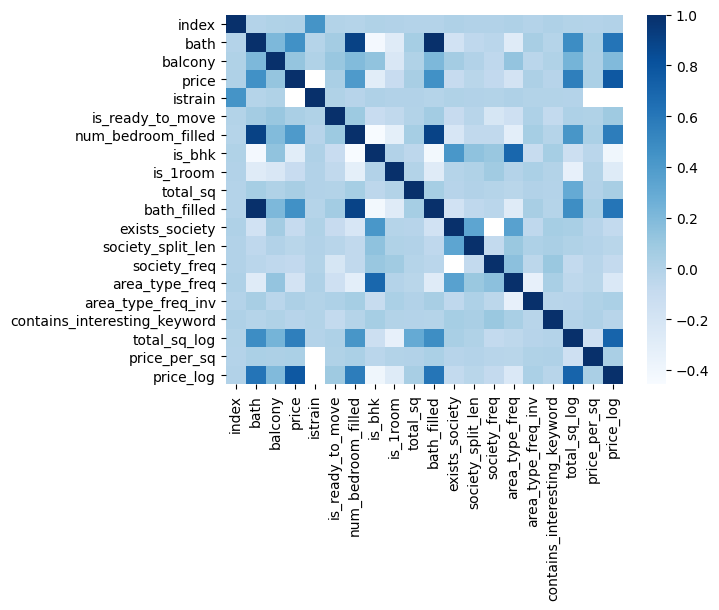

In [535]:
sns.heatmap(traintest.corr(), cmap="Blues")

In [213]:
traintest.groupby("location").mean().sort_values("price_per_sq", ascending=False)

,bath,balcony,price,istrain,is_ready_to_move,num_bedroom_filled,is_1room,total_sq,price_per_sq
location,,,,,,,,,
grihalakshmi layout,2.0,2.000000,150.000000,1.000000,1.000000,5.000000,0.0,24.000000,6.250000
srirampuram,2.8,2.000000,182.200000,1.000000,1.000000,3.200000,0.0,754.400000,4.810041
suragajakkanahalli,3.0,2.000000,73.000000,1.000000,0.000000,3.000000,0.0,605.500000,3.393636
weavers colony,1.0,0.333333,27.333333,1.000000,0.666667,1.000000,0.0,546.333333,0.688013
raghuvanahalli,2.0,1.333333,180.860000,0.833333,1.000000,1.833333,0.0,909.166667,0.386479
...,...,...,...,...,...,...,...,...,...
vivekananda nagar,3.0,2.000000,NaN,0.000000,0.000000,3.000000,0.0,1650.000000,NaN
vyalikaval hbcs layout,2.0,2.000000,NaN,0.000000,1.000000,3.000000,0.0,1443.000000,NaN
"yelahanka, north",2.0,2.000000,NaN,0.000000,1.000000,3.000000,0.0,1512.000000,NaN


In [533]:
traintest.groupby("area_type").mean()

,index,bath,balcony,price,istrain,is_ready_to_move,num_bedroom_filled,is_bhk,is_1room,total_sq,bath_filled,exists_society,society_split_len,society_freq,area_type_freq,total_sq_log,price_per_sq,price_log,contains_interesting_keyword
area_type,,,,,,,,,,,,,,,,,,,
Built-up Area,6049.025670,2.649869,1.469650,104.285498,0.899554,0.883185,2.796131,0.788318,0.062872,2226.021920,2.647693,0.502604,1.128348,9.189489,2688.0,7.257178,0.073933,4.347397,0.282738
Carpet Area,5745.402062,2.567010,1.413043,89.502356,0.896907,0.742268,2.721649,0.948454,0.123711,1352.313308,2.567010,0.628866,1.309278,9.475410,97.0,7.030441,0.092025,4.260199,0.175258
Plot Area,5942.304958,3.893410,1.394393,208.495486,0.888548,0.880211,4.051777,0.000439,0.035981,3346.879416,3.878455,0.148749,1.031154,4.386431,2279.0,7.304047,0.180618,4.988157,0.220272
Super built-up Area,6105.115242,2.434576,1.655947,92.971757,0.902835,0.748870,2.525370,0.998767,0.047864,1485.284337,2.432210,0.710867,1.166906,15.506141,9736.0,7.215995,0.056897,4.272828,0.287387


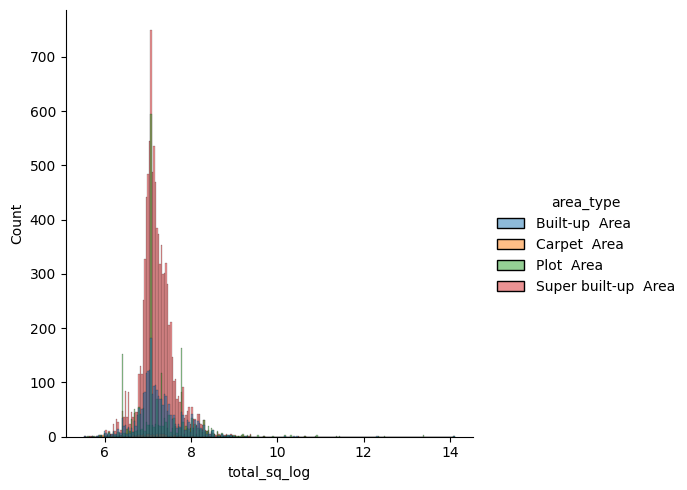

In [488]:
traintest["total_sq_log"] = np.log(traintest["total_sq"])
sns.displot(traintest, x="total_sq_log", hue="area_type")

In [485]:
traintest["price_per_sq_log"] = np.log(traintest.price_per_sq)

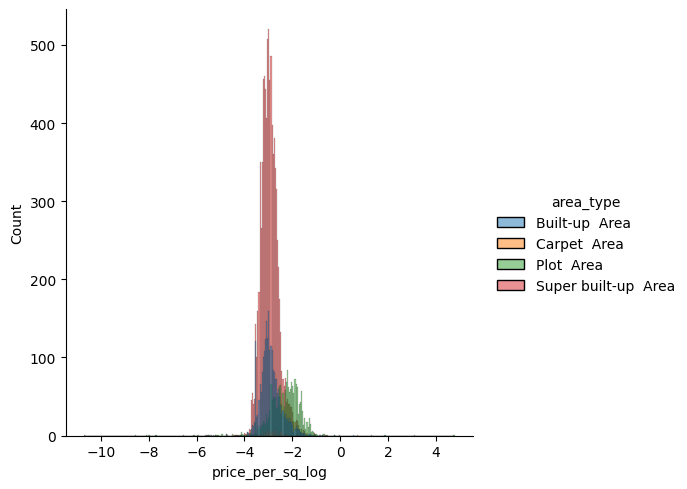

In [486]:
sns.displot(traintest, x="price_per_sq_log", hue="area_type")

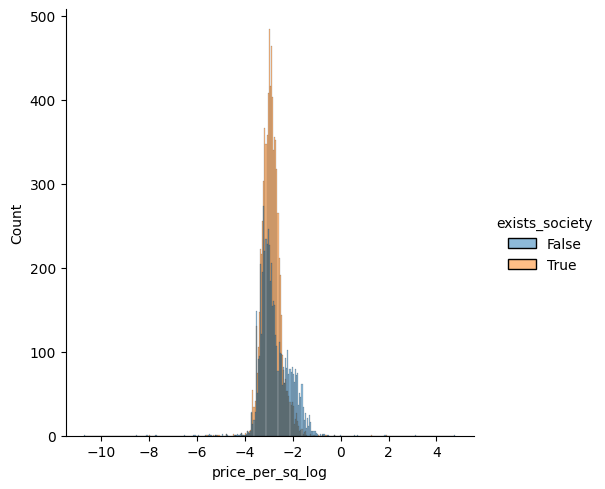

In [489]:
sns.displot(traintest, x="price_per_sq_log", hue="exists_society")

<AxesSubplot:xlabel='total_sq_log', ylabel='price_per_sq_log'>

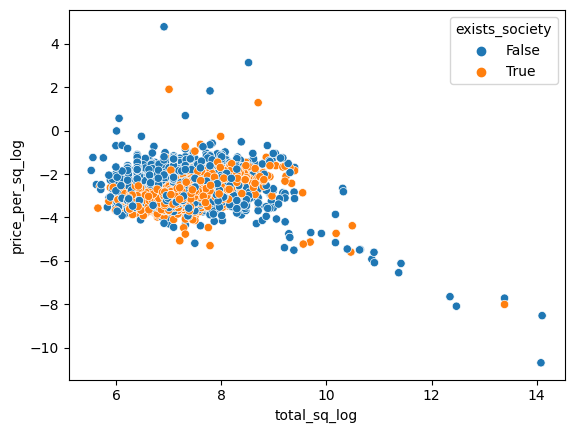

In [502]:
sns.scatterplot(
    data=traintest, x="total_sq_log", y="price_per_sq_log", hue="exists_society"
)

<AxesSubplot:>

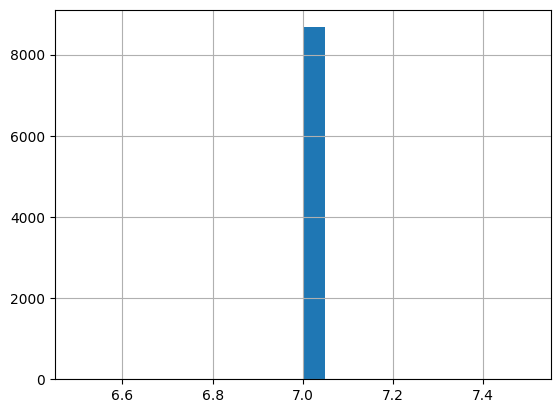

In [508]:
traintest.society.str.len().hist(bins=20)

In [398]:
iso_forest = IsolationForest()
iso_forest.fit(
    traintest[traintest.istrain == 1][
        ["bath_filled", "num_bedroom_filled", "total_sq", "area_type_freq"]
    ]
)

IsolationForest()

In [400]:
outliers = iso_forest.predict(
    traintest[traintest.istrain == 1][
        ["bath_filled", "num_bedroom_filled", "total_sq", "area_type_freq"]
    ]
)

In [401]:
len(outliers)

13320

In [425]:
traintest[traintest.price < 5]

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,...,is_1room,total_sq,bath_filled,avai_month_filled,avai_date_filled,exists_society,society_filled,society_freq,area_type_freq,price_per_sq


In [221]:
traintest.price_per_sq.describe()

count    13320.000000
mean         0.079028
std          1.062492
min          0.000023
25%          0.042623
50%          0.054286
75%          0.073132
max        120.000000
Name: price_per_sq, dtype: float64

In [225]:
traintest[traintest.location.isnull()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,istrain,is_ready_to_move,avai_date,avai_month,area_size,num_bedroom,num_bedroom_filled,is_bhk,is_1room,total_sq,price_per_sq
568,Super built-up Area,Ready To Move,NaN,3 BHK,Grare S,1600,3.0,2.0,86.0,1,True,NaN,NaN,3 BHK,3,3,True,False,1600.0,0.05375


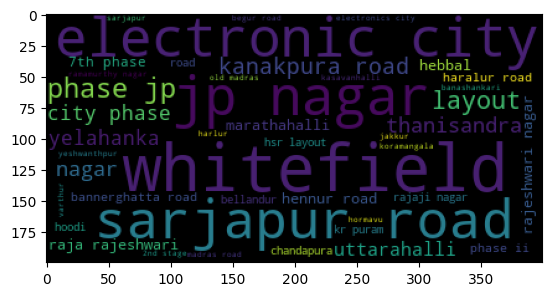

In [262]:
all_locations = " ".join(traintest.location)
all_locations = re.sub("[^\w ]", "", all_locations)
# cloud = wordcloud.WordCloud(random_state=42).generate(" ".join(traintest.location).split())
cloud = wordcloud.WordCloud(random_state=42).generate(all_locations)
plt.imshow(cloud)
# plt.show()

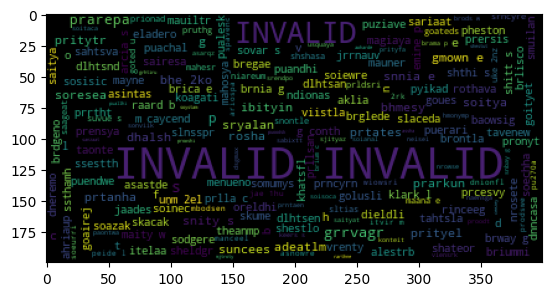

In [338]:
all_society = " ".join(traintest.society_filled.astype(str))
all_society = re.sub("[^\w ]", "", all_society)
# cloud = wordcloud.WordCloud(random_state=42).generate(" ".join(traintest.location).split())
cloud = wordcloud.WordCloud(random_state=42).generate(all_society)
plt.imshow(cloud)
# plt.show()

In [ ]:
location_popularity = defaultdict(int)
for l in all_locations.split():
    location_popularity[l] += 1
pprint(sorted(location_popularity.items(), key=lambda x: x[1], reverse=True)[:100])

In [263]:
all_locations[:1000]

'electronic city phase ii chikka tirupathi uttarahalli lingadheeranahalli kothanur whitefield old airport road rajaji nagar marathahalli gandhi bazar whitefield whitefield 7th phase jp nagar gottigere sarjapur mysore road bisuvanahalli raja rajeshwari nagar ramakrishnappa layout manayata tech park kengeri binny pete thanisandra bellandur  thanisandra mangammanapalya electronic city whitefield ramagondanahalli electronic city yelahanka bisuvanahalli hebbal raja rajeshwari nagar kasturi nagar kanakpura road electronics city phase 1 kundalahalli chikkalasandra uttarahalli murugeshpalya sarjapur  road ganga nagar yelahanka kanakpura road hsr layout doddathoguru whitefield kr puram himagiri meadows adarsh nagar bhoganhalli whitefield lakshminarayana pura yelahanka begur road devanahalli ramakrishnappa layout murugeshpalya govindaraja nagar ward tharabanahalli ganga nagar whitefield varthur bommanahalli doddathoguru gunjur marathahalli devarachikkanahalli kanakpura road double road begur roa

In [260]:
str(' ' .traintest.location)

'0       electronic city phase ii\n1               chikka tirupathi\n2                    uttarahalli\n3             lingadheeranahalli\n4                       kothanur\n                  ...           \n1475                 vittasandra\n1476                   gottigere\n1477                channasandra\n1478                 tumkur road\n1479          7th phase jp nagar\nName: location, Length: 14800, dtype: object'

In [143]:
a = FunctionTransformer(lambda x: x.map(x.value_counts()) / len(x))
a.fit_transform(traintest.area_type)

0       0.657838
1       0.153986
2       0.181622
3       0.657838
4       0.657838
          ...   
1475    0.657838
1476    0.657838
1477    0.657838
1478    0.181622
1479    0.181622
Name: area_type, Length: 14800, dtype: float64

In [457]:
xgboost_processor = ColumnTransformer(
    transformers=[
        (
            "passthrough",
            FunctionTransformer(lambda x: x),
            [
                "is_ready_to_move",
                "num_bedroom",
                "is_bhk",
                "is_1room",
                "balcony",
                "bath",
            ],
        ),
        (
            "log_transform",
            FunctionTransformer(lambda x: x.apply(np.log, axis=1)),
            ["total_sq"],
        ),
        (
            "freq_encoding",
            FunctionTransformer(
                lambda x: x.apply(lambda i: i.map(i.value_counts()) / len(x), axis=1)
            ),
            ["area_type", "avai_date", "avai_month", "location", "society"],
        ),
    ]
)

xgboost_pipe = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                [
                    ("others", xgboost_processor),
                    (
                        "location",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["location"]),
                                ),
                                (
                                    "vectorizer",
                                    CountVectorizer(ngram_range=(1, 2)),
                                ),
                            ]
                        ),
                    ),
                ],
            ),
        )
    ],
)

xgboost_pipeline = make_pipeline(xgboost_pipe, XGBRegressor(random_state=42))
cv(xgboost_pipeline)

NotFittedError: All estimators failed to fit

In [233]:
submit(xgboost_pipeline)

done


In [319]:
traintest.society.value_counts()

grrvagr    92
prarepa    78
prtates    64
sryalan    63
bhmesy     63
           ..
gciewty     1
nanorkr     1
kantsce     1
skesta      1
shidei      1
Name: society, Length: 2829, dtype: int64

In [358]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14800 entries, 0 to 1479
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   area_type           14800 non-null  category
 1   availability        14800 non-null  object  
 2   location            14800 non-null  object  
 3   size                14782 non-null  object  
 4   society             8672 non-null   object  
 5   total_sqft          14800 non-null  object  
 6   bath                14720 non-null  float64 
 7   balcony             14122 non-null  float64 
 8   price               13320 non-null  float64 
 9   istrain             14800 non-null  int64   
 10  is_ready_to_move    14800 non-null  bool    
 11  avai_date           3039 non-null   object  
 12  avai_month          3039 non-null   object  
 13  area_size           14782 non-null  object  
 14  num_bedroom         14782 non-null  object  
 15  num_bedroom_filled  14800 non-null  i

In [459]:
traintest.society.value_counts()

grrvagr    92
prarepa    78
prtates    64
sryalan    63
bhmesy     63
           ..
gciewty     1
nanorkr     1
kantsce     1
skesta      1
shidei      1
Name: society, Length: 2829, dtype: int64

In [556]:
lgbm_processor = ColumnTransformer(
    transformers=[
        (
            "passthrough",
            FunctionTransformer(lambda x: x),
            ["num_bedroom_filled", "balcony", "bath", "area_type_freq_inv"],
        ),
        (
            "type_cast",
            FunctionTransformer(lambda x: x.apply(lambda y: y.astype(int), axis=1)),
            [
                "is_ready_to_move",
                "is_bhk",
                "is_1room",
                "exists_society",
                "contains_interesting_keyword",
            ],
        ),
        (
            "log_transform",
            FunctionTransformer(lambda x: x.apply(np.log, axis=1)),
            ["total_sq"],
        ),
        #         (
        #             "freq_encoding",
        #             FunctionTransformer(
        #                 lambda x: x.apply(lambda i: i.map(i.value_counts()) / len(x), axis=1)
        #             ),
        #             [
        #                 #                 "area_type",
        #                 "avai_date_filled",
        #                 "avai_month_filled",
        #             ],
        #         ),
    ]
)


lgbm_pipe = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                [
                    ("others", lgbm_processor),
                    (
                        "location",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["location"]),
                                ),
                                (
                                    "vectorizer",
                                    CountVectorizer(ngram_range=(1, 2)),
                                ),
                            ]
                        ),
                    ),
                ],
            ),
        )
    ],
)

lgbm_pipeline = Pipeline(
    [
        ("processor", lgbm_pipe),
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(random_state=42)),
    ]
)
# cv(lgbm_pipeline)

xgboost_pipeline = make_pipeline(
    lgbm_pipe, SimpleImputer(strategy="median"), XGBRegressor(random_state=42)
)

catboost_pipeline = make_pipeline(
    lgbm_pipe, SimpleImputer(strategy="median"), CatBoostRegressor(random_state=42)
)

voting_tree_pipeline = VotingRegressor(
    estimators=[
        ("xgboost", xgboost_pipeline),
        ("lgbm", lgbm_pipeline),
        ("catboost", catboost_pipeline),
    ]
)


cv(voting_tree_pipeline)

{'fit_time': array([21.41376996, 21.52486587, 21.50533986, 21.41555572, 21.42297387]),
 'score_time': array([1.43867517, 1.42356205, 1.42102814, 1.46351624, 1.44190121]),
 'test_score': array([0.87259065, 0.87597054, 0.86619598, 0.87203633, 0.87224486])}
0.8718076718147092


In [560]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   index                         14800 non-null  int64   
 1   area_type                     14800 non-null  category
 2   availability                  14800 non-null  object  
 3   location                      14800 non-null  object  
 4   size                          14782 non-null  object  
 5   society                       8672 non-null   object  
 6   total_sqft                    14800 non-null  object  
 7   bath                          14720 non-null  float64 
 8   balcony                       14122 non-null  float64 
 9   price                         13320 non-null  float64 
 10  istrain                       14800 non-null  int64   
 11  is_ready_to_move              14800 non-null  bool    
 12  avai_date                     3039 non-null   

In [577]:
mlp_processor = ColumnTransformer(
    transformers=[
        (
            "passthrough",
            FunctionTransformer(lambda x: x),
            [
                "num_bedroom_filled",
                "balcony",
                "bath",
                "area_type_freq_inv",
                "total_sq_log",
            ],
        ),
        #         (
        #             "type_cast",
        #             FunctionTransformer(lambda x: x.apply(lambda y: y.astype(int), axis=1)),
        #             [
        #                 "is_ready_to_move",
        #                 "is_bhk",
        #                 "is_1room",
        #                 "exists_society",
        #                 "contains_interesting_keyword",
        #             ],
        #         ),
        #         (
        #             "log_transform",
        #             FunctionTransformer(lambda x: x.apply(np.log, axis=1)),
        #             ["total_sq"],
        #         ),
        #         (
        #             "freq_encoding",
        #             FunctionTransformer(
        #                 lambda x: x.apply(lambda i: i.map(i.value_counts()) / len(x), axis=1)
        #             ),
        #             ["area_type", "avai_date_filled", "avai_month_filled"],
        #         ),
    ]
)

mlp_numeric_pipe = Pipeline(
    [
        ("processor", mlp_processor),
        ("impute", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ]
)


mlp_pipe = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                [
                    ("others", mlp_numeric_pipe),
                    (
                        "binary",
                        FunctionTransformer(
                            lambda x: x[
                                [
                                    "is_ready_to_move",
                                    "is_bhk",
                                    "is_1room",
                                    "exists_society",
                                    "contains_interesting_keyword",
                                ]
                            ]
                        ),
                    ),
                    (
                        "location",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["location"]),
                                ),
                                (
                                    "vectorizer",
                                    CountVectorizer(ngram_range=(1, 2)),
                                ),
                            ]
                        ),
                    ),
                ],
            ),
        )
    ],
)

mlp_pipeline = make_pipeline(
    mlp_numeric_pipe, MLPRegressor(random_state=42, hidden_layer_sizes=(30, 10, 10))
)

adaboost_pipeline = make_pipeline(mlp_numeric_pipe, AdaBoostRegressor())

linear_pipeline = make_pipeline(mlp_numeric_pipe, LinearRegression())


voting_linear_pipeline = VotingRegressor(
    estimators=[
        ("ada", adaboost_pipeline),
        ("mlp", mlp_pipeline),
        ("linear", linear_pipeline),
    ]
)

cv(voting_linear_pipeline)

{'fit_time': array([6.73909712, 6.71904087, 4.66423106, 6.75716186, 6.72771811]),
 'score_time': array([0.01004291, 0.00964999, 0.01056004, 0.0093379 , 0.00905395]),
 'test_score': array([0.82078574, 0.83182054, 0.82078111, 0.82164354, 0.82254058])}
0.8235143023247191


In [567]:
stack = StackingRegressor(
    [
        ("xgboost", xgboost_pipeline),
        ("lgbm", lgbm_pipeline),
        ("adaboost", adaboost_pipeline),
        ("catboost", catboost_pipeline),
        ("tree_avg", voting_tree_pipeline),
        ("linear_avg", voting_linear_pipeline),
        ("mlp", mlp_pipeline),
        ("ada", adaboost_pipeline),
        ("linear", linear_pipeline),
    ]
)
cv(stack)

{'fit_time': array([331.18690991, 333.34068298, 328.23214316, 319.65300369,
       330.60295415]),
 'score_time': array([2.81179905, 2.73527193, 3.00163102, 2.75862694, 3.04375005]),
 'test_score': array([0.8744215 , 0.87609859, 0.86708365, 0.87301001, 0.87369683])}
0.8728621165512559


In [568]:
submit(stack)

Learning rate set to 0.061882
0:	learn: 0.6929193	total: 7.62ms	remaining: 7.61s
1:	learn: 0.6665175	total: 14.6ms	remaining: 7.26s
2:	learn: 0.6418404	total: 22ms	remaining: 7.3s
3:	learn: 0.6193972	total: 28.8ms	remaining: 7.16s
4:	learn: 0.5988272	total: 35.4ms	remaining: 7.04s
5:	learn: 0.5797137	total: 42.3ms	remaining: 7s
6:	learn: 0.5620031	total: 49.1ms	remaining: 6.97s
7:	learn: 0.5455883	total: 55.5ms	remaining: 6.88s
8:	learn: 0.5310643	total: 62.2ms	remaining: 6.85s
9:	learn: 0.5168393	total: 69ms	remaining: 6.83s
10:	learn: 0.5033027	total: 75.8ms	remaining: 6.82s
11:	learn: 0.4916722	total: 82.6ms	remaining: 6.8s
12:	learn: 0.4806068	total: 89.2ms	remaining: 6.77s
13:	learn: 0.4702709	total: 96.2ms	remaining: 6.77s
14:	learn: 0.4614119	total: 103ms	remaining: 6.76s
15:	learn: 0.4534665	total: 110ms	remaining: 6.74s
16:	learn: 0.4462288	total: 116ms	remaining: 6.72s
17:	learn: 0.4391111	total: 123ms	remaining: 6.7s
18:	learn: 0.4326852	total: 129ms	remaining: 6.68s
19:	lea

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate set to 0.059472
0:	learn: 0.6978135	total: 7.07ms	remaining: 7.06s
1:	learn: 0.6735235	total: 13.5ms	remaining: 6.75s
2:	learn: 0.6501458	total: 20ms	remaining: 6.63s
3:	learn: 0.6280998	total: 26.4ms	remaining: 6.58s
4:	learn: 0.6073486	total: 32.9ms	remaining: 6.54s
5:	learn: 0.5887115	total: 39.3ms	remaining: 6.5s
6:	learn: 0.5701160	total: 45.6ms	remaining: 6.47s
7:	learn: 0.5546155	total: 52ms	remaining: 6.45s
8:	learn: 0.5401957	total: 58.5ms	remaining: 6.44s
9:	learn: 0.5259512	total: 64.5ms	remaining: 6.38s
10:	learn: 0.5126256	total: 70.5ms	remaining: 6.33s
11:	learn: 0.5005782	total: 76.6ms	remaining: 6.31s
12:	learn: 0.4897755	total: 82.7ms	remaining: 6.28s
13:	learn: 0.4790697	total: 88.9ms	remaining: 6.26s
14:	learn: 0.4699447	total: 94.9ms	remaining: 6.23s
15:	learn: 0.4613453	total: 101ms	remaining: 6.24s
16:	learn: 0.4536095	total: 108ms	remaining: 6.24s
17:	learn: 0.4468336	total: 114ms	remaining: 6.2s
18:	learn: 0.4400966	total: 120ms	remaining: 6.18s
19

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

done


In [268]:
traintest.avai_date.value_counts().keys()

Index(['18', '19', '20', '21', '17', '22', '16', '15', '14'], dtype='object')

In [265]:
traintest.avai_month.value_counts()

Dec    831
May    374
Apr    325
Aug    277
Mar    270
Jul    229
Jun    217
Jan    143
Oct    101
Sep     94
Nov     93
Feb     85
Name: avai_month, dtype: int64

In [266]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14800 entries, 0 to 1479
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area_type           14800 non-null  object 
 1   availability        14800 non-null  object 
 2   location            14800 non-null  object 
 3   size                14782 non-null  object 
 4   society             8672 non-null   object 
 5   total_sqft          14800 non-null  object 
 6   bath                14720 non-null  float64
 7   balcony             14122 non-null  float64
 8   price               13320 non-null  float64
 9   istrain             14800 non-null  int64  
 10  is_ready_to_move    14800 non-null  bool   
 11  avai_date           3039 non-null   object 
 12  avai_month          3039 non-null   object 
 13  area_size           14782 non-null  object 
 14  num_bedroom         14782 non-null  object 
 15  num_bedroom_filled  14800 non-null  int64  
 16  is_bh

In [269]:
traintest.balcony.value_counts()

2.0    5658
1.0    5444
3.0    1861
0.0    1159
Name: balcony, dtype: int64